In [1]:
%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

# RNA-seq analysis pipeline with enrichment analysis from Enrichr 
---

By default, we use TCGA data. Users can optionally also upload their own datasets. See the example files in `/example_data` for the proper format.

In [7]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from umap import UMAP
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from maayanlab_bioinformatics.dge import characteristic_direction
from maayanlab_bioinformatics.normalization import log2_normalize, filter_by_var, zscore_normalize
from maayanlab_bioinformatics.utils import merge
import plotly.express as px
import math
from collections import OrderedDict
import json
from jupyter_d3 import scatter_plot
from IPython.display import display, HTML

In [9]:
%%appyter hide_code

{% do SectionField(
    name="DATASET",
    title="Dataset selection",
    subtitle='If using ',
    img = "tcga-logo.png"
) %}


{% do SectionField(
    name='CONFIG',
    title='Analysis parameters',
    img = "cluster-icon.svg"

) %}

{% do SectionField(
    name="ENRICHR_LIBS",
    title="Libraries to include in the Enrichr search",
    img = "enrichr-logo.png"


) %}

UsageError: Cell magic `%%appyter` not found.


In [ ]:
%%appyter code_eval

data_filename = "{{ FileField(name='data_filename', label='RNA-seq data file (.csv)', description='Upload RNA-seq dataset in csv format. The index of the dataset are genes, the columns are samples. Leave blank if using TCGA data.', section='DATASET').value }}"

clinical_data_filename = "{{ FileField(name='clinical_data_filename', label='Clinical data file (.csv)', description='Upload clinical data in csv format. The first column should contain patient IDs corresponding to those in the RNA-seq file. Each subsequent column is a clinical data field. Leave blank if using TCGA data.', section='DATASET').value }}"

cancer = '''{{ ChoiceField(
        name = "cancer",
        label = "Cancer type",
        description="The value provided as the primary diagnosis on cases in TCGA.",
        choices=["Infiltrating duct carcinoma, NOS","Squamous cell carcinoma, NOS","Lobular carcinoma, NOS","Acute myeloid leukemia, NOS","Hepatocellular carcinoma, NOS","Serous cystadenocarcinoma, NOS","Endometrioid adenocarcinoma, NOS","Adenocarcinoma, NOS","Clear cell adenocarcinoma, NOS","Glioblastoma","Mucinous adenocarcinoma","Transitional cell carcinoma","Malignant melanoma, NOS","Papillary adenocarcinoma, NOS"],
        section="DATASET",
        default="Serous cystadenocarcinoma, NOS" ) 
}}'''
    
# Dimensionality reduction parameters

n_pca_components = {{IntField(
    name='n_pca_components',
    label='Number of PCA components to use for UMAP',
    description='The number of \'top\' PCA components to use for further dimensionality reduction using the UMAP algorithm',
    default=10,
    min=0,
    max=100,
    section='CONFIG',
)}}

n_neighbors = {{IntField(
    name='n_neighbors',
    label='Number of neighbors for each projected datapoint computed by UMAP',
    description='Smaller values preserve local manifold structure in the dataset as opposed to overall global structure',
    default=2,
    min=2,
    max=20,
    section='CONFIG',
)}}

min_cluster_dist = {{FloatField(
    name='min_cluster_dist',
    label='Minimum distance between UMAP-projected points',
    description='How tightly packed points produced by dimensionality reduction with UMAP are permitted to be.',
    default=0.3,
    min=0.1,
    max=1,
    section='CONFIG',
)}}


# The number of 'top' genes to use for differential expression
top_n_genes = {{IntField(
    name='top_n_genes',
    label='Number of Genes',
    description='The number of \'top\' genes to use for differential expression',
    default=250,
    min=100,
    max=1000,
    section='CONFIG',
)}}

# The number of 'top' results to keep from enrichment analysis
top_n_results = {{ IntField(
    name='top_n_results',
    label='Number of Top Enrichment Results',
    description='The number of \'top\' results to keep from enrichment analysis',
    default=5,
    min=1,
    max=100,
    section='CONFIG',
)}}

transcription_libraries = {{ MultiChoiceField(name='transcription_libraries', 
                                              description='Select the Enrichr libraries you would like in your figure.', 
                                              label='Transcription', 
                                              default=[], 
                                              section = 'ENRICHR_LIBS',
                                              choices=[
                                                    'ARCHS4_TFs_Coexp',
                                                    'ChEA_2016',
                                                    'ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X',
                                                    'ENCODE_Histone_Modifications_2015',
                                                    'ENCODE_TF_ChIP-seq_2015',
                                                    'Epigenomics_Roadmap_HM_ChIP-seq',
                                                    'Enrichr_Submissions_TF-Gene_Coocurrence',
                                                    'Genome_Browser_PWMs',
                                                    'lncHUB_lncRNA_Co-Expression',
                                                    'miRTarBase_2017',
                                                    'TargetScan_microRNA_2017',
                                                    'TF-LOF_Expression_from_GEO',
                                                    'TF_Perturbations_Followed_by_Expression',
                                                    'Transcription_Factor_PPIs',
                                                    'TRANSFAC_and_JASPAR_PWMs',
                                                    'TRRUST_Transcription_Factors_2019'
                                                ]) }}

pathways_libraries = {{ MultiChoiceField(name='pathways_libraries', 
                                         description='Select the Enrichr libraries you would like in your figure.', 
                                         label='Pathways', 
                                         default=[], 
                                         section='ENRICHR_LIBS',
                                         choices=[
                                                    'ARCHS4_Kinases_Coexp',
                                                    'BioCarta_2016',
                                                    'BioPlanet_2019',
                                                    'BioPlex_2017',
                                                    'CORUM',
                                                    'Elsevier_Pathway_Collection',
                                                    'HMS_LINCS_KinomeScan',
                                                    'HumanCyc_2016',
                                                    'huMAP',
                                                    'KEA_2015',
                                                    'KEGG_2019_Human',
                                                    'KEGG_2019_Mouse',
                                                    'Kinase_Perturbations_from_GEO_down',
                                                    'Kinase_Perturbations_from_GEO_up',
                                                    'L1000_Kinase_and_GPCR_Perturbations_down',
                                                    'L1000_Kinase_and_GPCR_Perturbations_up',
                                                    'NCI-Nature_2016',
                                                    'NURSA_Human_Endogenous_Complexome',
                                                    'Panther_2016',
                                                    'Phosphatase_Substrates_from_DEPOD',
                                                    'PPI_Hub_Proteins',
                                                    'Reactome_2016',
                                                    'SILAC_Phosphoproteomics',
                                                    'SubCell_BarCode',
                                                    'Virus-Host_PPI_P-HIPSTer_2020',
                                                    'WikiPathways_2019_Human',
                                                    'WikiPathways_2019_Mouse']) }} 

ontologies_libraries = {{ MultiChoiceField(name='ontologies_libraries', 
                                           description='Select the Enrichr libraries you would like in your figure.', 
                                           label='Ontologies', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[
                                                'GO_Biological_Process_2018',
                                                'GO_Cellular_Component_2018',
                                                'GO_Molecular_Function_2018',
                                                'Human_Phenotype_Ontology',
                                                'Jensen_COMPARTMENTS',
                                                'Jensen_DISEASES',
                                                'Jensen_TISSUES',
                                                'MGI_Mammalian_Phenotype_Level_4_2019'
                                           ]) }}
    
diseases_drugs_libraries = {{ MultiChoiceField(name='diseases_drugs_libraries', 
                                               description='Select the Enrichr libraries you would like in your figure.', 
                                               label='Diseases/Drugs', 
                                               default=[], 
                                               section = 'ENRICHR_LIBS',
                                               choices=[    
                                                    'Achilles_fitness_decrease',
                                                    'Achilles_fitness_increase',
                                                    'ARCHS4_IDG_Coexp',
                                                    'ClinVar_2019',
                                                    'dbGaP',
                                                    'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
                                                    'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
                                                    'DisGeNET',
                                                    'DrugMatrix',
                                                    'DSigDB',
                                                    'GeneSigDB',
                                                    'GWAS_Catalog_2019',
                                                    'LINCS_L1000_Chem_Pert_down',
                                                    'LINCS_L1000_Chem_Pert_up',
                                                    'LINCS_L1000_Ligand_Perturbations_down',
                                                    'LINCS_L1000_Ligand_Perturbations_up',
                                                    'MSigDB_Computational',
                                                    'MSigDB_Oncogenic_Signatures',
                                                    'Old_CMAP_down',
                                                    'Old_CMAP_up',
                                                    'OMIM_Disease',
                                                    'OMIM_Expanded',
                                                    'PheWeb_2019',
                                                    'Rare_Diseases_AutoRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_AutoRIF_Gene_Lists',
                                                    'Rare_Diseases_GeneRIF_ARCHS4_Predictions',
                                                    'Rare_Diseases_GeneRIF_Gene_Lists',
                                                    'UK_Biobank_GWAS_v1',
                                                    'Virus_Perturbations_from_GEO_down',
                                                    'Virus_Perturbations_from_GEO_up',
                                                    'VirusMINT']) }}
    
cell_types_libraries = {{ MultiChoiceField(name='cell_types_libraries', 
                                           description='Select the Enrichr libraries you would like in your figure.', 
                                           label='Cell Types', 
                                           default=[], 
                                           section = 'ENRICHR_LIBS',
                                           choices=[        
                                                'Allen_Brain_Atlas_down',
                                                'Allen_Brain_Atlas_up',
                                                'ARCHS4_Cell-lines',
                                                'ARCHS4_Tissues',
                                                'Cancer_Cell_Line_Encyclopedia',
                                                'CCLE_Proteomics_2020',
                                                'ESCAPE',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_down',
                                                'GTEx_Tissue_Sample_Gene_Expression_Profiles_up',
                                                'Human_Gene_Atlas',
                                                'Mouse_Gene_Atlas',
                                                'NCI-60_Cancer_Cell_Lines',
                                                'ProteomicsDB_2020',
                                                'Tissue_Protein_Expression_from_Human_Proteome_Map']) }}    
    
    
    
miscellaneous_libraries = {{ MultiChoiceField(name='miscellaneous_libraries', 
                                              description='Select the Enrichr libraries you would like in your figure.', 
                                              label='Miscellaneous', 
                                              default=[], 
                                              section = 'ENRICHR_LIBS',
                                              choices=[            
                                                    'Chromosome_Location_hg19',
                                                    'Data_Acquisition_Method_Most_Popular_Genes',
                                                    'Enrichr_Libraries_Most_Popular_Genes',
                                                    'Genes_Associated_with_NIH_Grants',
                                                    'HMDB_Metabolites',
                                                    'HomoloGene',
                                                    'InterPro_Domains_2019',
                                                    'NIH_Funded_PIs_2017_AutoRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions',
                                                    'NIH_Funded_PIs_2017_Human_AutoRIF',
                                                    'NIH_Funded_PIs_2017_Human_GeneRIF',
                                                    'Pfam_Domains_2019',
                                                    'Pfam_InterPro_Domains',
                                                    'Table_Mining_of_CRISPR_Studies']) }}    
    
    
legacy_libraries = {{ MultiChoiceField(name='legacy_libraries', 
                                       description='Select the Enrichr libraries you would like in your figure.', 
                                       label='Legacy', 
                                       default=[], 
                                       section = 'ENRICHR_LIBS',
                                       choices=[                
                                            'BioCarta_2013',
                                            'BioCarta_2015',
                                            'ChEA_2013',
                                            'ChEA_2015',
                                            'Chromosome_Location',
                                            'Disease_Signatures_from_GEO_down_2014',
                                            'Disease_Signatures_from_GEO_up_2014',
                                            'Drug_Perturbations_from_GEO_2014',
                                            'ENCODE_Histone_Modifications_2013',
                                            'ENCODE_TF_ChIP-seq_2014',
                                            'GO_Biological_Process_2013',
                                            'GO_Biological_Process_2015',
                                            'GO_Biological_Process_2017',
                                            'GO_Biological_Process_2017b',
                                            'GO_Cellular_Component_2013',
                                            'GO_Cellular_Component_2015',
                                            'GO_Cellular_Component_2017',
                                            'GO_Cellular_Component_2017b',
                                            'GO_Molecular_Function_2013',
                                            'GO_Molecular_Function_2015',
                                            'GO_Molecular_Function_2017',
                                            'GO_Molecular_Function_2017b',
                                            'HumanCyc_2015',
                                            'KEA_2013',
                                            'KEGG_2013',
                                            'KEGG_2015',
                                            'KEGG_2016',
                                            'MGI_Mammalian_Phenotype_2013',
                                            'MGI_Mammalian_Phenotype_2017',
                                            'MGI_Mammalian_Phenotype_Level_3',
                                            'MGI_Mammalian_Phenotype_Level_4',
                                            'NCI-Nature_2015',
                                            'Panther_2015',
                                            'Reactome_2013',
                                            'Reactome_2015',
                                            'TargetScan_microRNA',
                                            'Tissue_Protein_Expression_from_ProteomicsDB',
                                            'WikiPathways_2013',
                                            'WikiPathways_2015',
                                            'WikiPathways_2016']) }} 

crowd_libraries = {{ MultiChoiceField(name='crowd_libraries', 
                                      description='Select the Enrichr libraries you would like in your figure.', 
                                      label='Crowd', 
                                      default=[],
                                      section = 'ENRICHR_LIBS',
                                      choices=[                
                                            'Aging_Perturbations_from_GEO_down',
                                            'Aging_Perturbations_from_GEO_up',
                                            'Disease_Perturbations_from_GEO_down',
                                            'Disease_Perturbations_from_GEO_up',
                                            'Drug_Perturbations_from_GEO_down',
                                            'Drug_Perturbations_from_GEO_up',
                                            'Gene_Perturbations_from_GEO_down',
                                            'Gene_Perturbations_from_GEO_up',
                                            'Ligand_Perturbations_from_GEO_down',
                                            'Ligand_Perturbations_from_GEO_up',
                                            'MCF7_Perturbations_from_GEO_down',
                                            'MCF7_Perturbations_from_GEO_up',
                                            'Microbe_Perturbations_from_GEO_down',
                                            'Microbe_Perturbations_from_GEO_up',
                                            'RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
                                            'SysMyo_Muscle_Gene_Sets']) }}

enrichr_libraries = OrderedDict([
    ('Diseases/Drugs', diseases_drugs_libraries), 
    ('Ontologies', ontologies_libraries),
    ('Cell Type', cell_types_libraries),
    ('Pathways', pathways_libraries),
    ('Transcription', transcription_libraries),
    ('Legacy', legacy_libraries),
    ('Crowd', crowd_libraries)
])

In [ ]:
%%appyter hide_code
'''
# values to test the notebook locally

cancer = "Glioblastoma"
# Dimensionality reduction parameters
n_pca_components = 10
n_neighbors = 2
min_cluster_dist = 0.3
# The number of 'top' genes to use for differential expression
top_n_genes = 250
# The number of 'top' results to keep from enrichment analysis
top_n_results = 5
transcription_libraries = []
pathways_libraries = [] 
ontologies_libraries = []
diseases_drugs_libraries = []
cell_types_libraries = []    
miscellaneous_libraries = ['Chromosome_Location_hg19']    
legacy_libraries = ['BioCarta_2013'] 
crowd_libraries = ['Disease_Perturbations_from_GEO_down']
enrichr_libraries = OrderedDict([
    ('Diseases/Drugs', diseases_drugs_libraries), 
    ('Ontologies', ontologies_libraries),
    ('Cell Type', cell_types_libraries),
    ('Pathways', pathways_libraries),
    ('Transcription', transcription_libraries),
    ('Legacy', legacy_libraries),
    ('Crowd', crowd_libraries)
])



data_filename = "./example_data/data.csv"
clinical_data_filename = "./example_data/clinical_data.csv"



'''


## Import dataset

If using user-uploaded data, we access those files and set the necessary index names.

Otherwise, we first download the data containing RNA-seq profiles for the selected cancer type from TCGA and the corresponding clinical data for those cases.

The RNA-seq data that is provided has already been processed using the HTSeq Python package, which calculates the number of mapped reads to each gene.

In [10]:
%%appyter hide_code

# Utility function for saving the dataset
def save_data(cancer_type,
              df_data_norm_km,
              df_data_norm_pca,
              df_data_norm_umap,
              df_diff_expr,
              df_aucs):
    
    # create the root dir
    root_dir = f'./processed_data/{cancer_type}'
    os.makedirs(root_dir, exist_ok=True)

    # /clustering/graphclust/clusters.csv
    #   Barcode,Cluster
    os.makedirs(f'{root_dir}/clustering/graphclust', exist_ok=True)
    df_data_norm_km.to_csv(f'{root_dir}/clustering/graphclust/clusters.csv')
    
    # /pca/10_components/projection.csv
    #   Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
    os.makedirs(f'{root_dir}/pca/{n_pca_components}_components', exist_ok=True)
    df_data_norm_pca.to_csv(f'{root_dir}/pca/{n_pca_components}_components/projection.csv')
    
    # /umap/2_components/projection.csv
    #   Barcode,UMAP-1,UMAP-2
    os.makedirs(f'{root_dir}/umap/2_components', exist_ok=True)
    df_data_norm_umap.to_csv(f'{root_dir}/umap/2_components/projection.csv')
    
     # /diffexp/graphclust/differential_expression.csv
    #   Feature Name,Cluster 2 Log2 fold change,Cluster 0 Log2 fold change,Cluster 1 Log2 fold change,Cluster 3 Log2 fold change,Cluster 2 Adjusted p value,Cluster 0 Adjusted p value,Cluster 1 Adjusted p value,Cluster 3 Adjusted p value,Cluster 2 Mean Counts,Cluster 0 Mean Counts,Cluster 1 Mean Counts,Cluster 3 Mean Counts,Feature Name
    os.makedirs(f'{root_dir}/diffexp/graphclust', exist_ok=True)
    df_diff_expr.to_csv(f'{root_dir}/diffexp/graphclust/differential_expression.csv')
    
    # /cluster_aucs.csv
    #   ,2,0,1,3
    df_aucs.to_csv(f'{root_dir}/cluster_aucs.csv')

UsageError: Cell magic `%%appyter` not found.


In [17]:
user_data = False
if (data_filename != "" and clinical_data_filename != ""): user_data = True


In [18]:
data_index = "symbol"
clinical_index = "case_id"

if (user_data):
    df_data = pd.read_csv(data_filename, index_col=0).sort_index()
    df_clinical = pd.read_csv(clinical_data_filename, index_col=0).sort_index()

    df_data.index.name = "symbol"
    df_clinical.index.name = "case_id"
    
    display(df_data.head())
    display(df_clinical.head())
else:
    # Import the RNA-seq and clinical DataFrames with only entries corresponding 
    # the selected cancer type
    aws_url = f'https://tcga-enrichr-viewer.s3.amazonaws.com/{cancer.replace(" ", "%20")}'

    df_data = pd.read_csv(f'{aws_url}_data.csv')
    df_data = df_data.set_index("symbol")

    df_clinical = pd.read_csv(f'{aws_url}_clinical_data.csv')
    df_clinical = df_clinical.set_index("case_id")
    df_clinical = df_clinical.replace("not reported", np.nan)


124c1d54-1836-4f8f-920f-14047376120f  \
symbol                                          
A1BG                                        4   
A1CF                                      522   
A2M                                     25332   
A2ML1                                    4846   
A3GALT2                                     4   

         261925e3-96e4-440c-8e95-c003d44ab2f2  \
symbol                                          
A1BG                                        5   
A1CF                                      584   
A2M                                     44002   
A2ML1                                       3   
A3GALT2                                     3   

         f5319fd5-beae-4ca8-8f42-45fca5e6a2d2  \
symbol                                          
A1BG                                        1   
A1CF                                        3   
A2M                                      3422   
A2ML1                                      25   
A3GALT2                                     1   

         92252560-5984-41f6-a4b5-a3aa8654c0c8  \
symbol                                          
A1BG                                        3   
A1CF                                        1   
A2M                                     10425   
A2ML1                                      46   
A3GALT2                                     1   

         abe658e0-33f9-4f57-849b-dec4d20964d6  \
symbol                                          
A1BG                                        8   
A1CF                                      291   
A2M                                     43786   
A2ML1                                       3   
A3GALT2                                     2   

         e5f956dd-f49f-435c-83c3-5b1b0a2050ed  \
symbol                                          
A1BG                                       36   
A1CF                                        5   
A2M                                     56200   
A2ML1                                      15   
A3GALT2                                     4   

         17c0ce0f-8227-4119-9b39-ea8db18f5f4b  \
symbol                                          
A1BG                                        2   
A1CF                                        1   
A2M                                     13729   
A2ML1                                      47   
A3GALT2                                     4   

         ae39e358-08d7-4367-ae68-82b469e791e4  \
symbol                                          
A1BG                                       15   
A1CF                                        1   
A2M                                     49519   
A2ML1                                      47   
A3GALT2                                     1   

         ae6c307a-ca04-4618-b270-e8641afd1daa  \
symbol                                          
A1BG                                        8   
A1CF                                       71   
A2M                                     65740   
A2ML1                                     595   
A3GALT2                                     7   

         b89267a4-0e6b-401e-85b0-e66775858aa6  ...  \
symbol                                         ...   
A1BG                                        9  ...   
A1CF                                     1416  ...   
A2M                                     39155  ...   
A2ML1                                       2  ...   
A3GALT2                                     1  ...   

         4be66108-e72a-406b-bb4b-f58ff2877336  \
symbol                                          
A1BG                                        1   
A1CF                                      161   
A2M                                      2148   
A2ML1                                       1   
A3GALT2                                     0   

         1eb2038d-3b4f-4da2-964b-e629ea068215  \
symbol                                          
A1BG                                       36   
A1CF                                      6

primary_diagnosis  treatments  \
case_id                                                                 
000d566c-96c7-4f1c-b36e-fa2222467983  Adenocarcinoma, NOS         NaN   
0011a67b-1ba9-4a32-a6b8-7850759a38cf  Adenocarcinoma, NOS         NaN   
0075437e-ba1a-46be-86d6-9773209a2b5e  Adenocarcinoma, NOS         NaN   
00781a96-4068-427c-a9c5-584d167c3dea  Adenocarcinoma, NOS         NaN   
007f9081-5093-4323-b4f8-cd510bf20705  Adenocarcinoma, NOS         NaN   

                                                submitter_id  \
case_id                                                        
000d566c-96c7-4f1c-b36e-fa2222467983  TCGA-KK-A7B2_diagnosis   
0011a67b-1ba9-4a32-a6b8-7850759a38cf  TCGA-DC-6158_diagnosis   
0075437e-ba1a-46be-86d6-9773209a2b5e  TCGA-62-A471_diagnosis   
00781a96-4068-427c-a9c5-584d167c3dea  TCGA-BR-8368_diagnosis   
007f9081-5093-4323-b4f8-cd510bf20705  TCGA-G9-6377_diagnosis   

                                      ann_arbor_clinical_stage icd_10_code  \
case_id                                                                      
000d566c-96c7-4f1c-b36e-fa2222467983                       NaN         C61   
0011a67b-1ba9-4a32-a6b8-7850759a38cf                       NaN         C20   
0075437e-ba1a-46be-86d6-9773209a2b5e                       NaN       C34.1   
00781a96-4068-427c-a9c5-584d167c3dea                       NaN       C16.1   
007f9081-5093-4323-b4f8-cd510bf20705                       NaN         C61   

                                     ajcc_clinical_n  \
case_id                                                
000d566c-96c7-4f1c-b36e-fa2222467983             NaN   
0011a67b-1ba9-4a32-a6b8-7850759a38cf             NaN   
0075437e-ba1a-46be-86d6-9773209a2b5e             NaN   
00781a96-4068-427c-a9c5-584d167c3dea             NaN   
007f9081-5093-4323-b4f8-cd510bf20705             NaN   

                                      wilms_tumor_histologic_subtype  \
case_id                                                                
000d566c-96c7-4f1c-b36e-fa2222467983                             NaN   
0011a67b-1ba9-4a32-a6b8-7850759a38cf                             NaN   
0075437e-ba1a-46be-86d6-9773209a2b5e                             NaN   
00781a96-4068-427c-a9c5-584d167c3dea                             NaN   
007f9081-5093-4323-b4f8-cd510bf20705                             NaN   

                                      metastasis_at_diagnosis  inrg_stage  \
case_id                                                                     
000d566c-96c7-4f1c-b36e-fa2222467983                      NaN         NaN   
0011a67b-1ba9-4a32-a6b8-7850759a38cf                      NaN         NaN   
0075437e-ba1a-46be-86d6-9773209a2b5e                      NaN         NaN   
00781a96-4068-427c-a9c5-584d167c3dea                      NaN         NaN   
007f9081-5093-4323-b4f8-cd510bf20705                      NaN         NaN   

                                      iss_stage  ...  margin_distance  \
case_id                                          ...                    
000d566c-96c7-4f1c-b36e-fa2222467983        NaN  ...              NaN   
0011a67b-1ba9-4a32-a6b8-7850759a38cf        NaN  ...              NaN   
0075437e-ba1a-46be-86d6-9773209a2b5e        NaN  ...              NaN   
00781a96-4068-427c-a9c5-584d167c3dea        NaN  ...              NaN   
007f9081-5093-4323-b4f8-cd510bf20705        NaN  ...              NaN   

                                      tumor_largest_dimension_diameter  \
case_id                                                                  
000d566c-96c7-4f1c-b36e-fa2222467983                               NaN   
0011a67b-1ba9-4a32-a6b8-7850759a38cf                               NaN   
0075437e-ba1a-46be-86d6-9773209a2b5e                               NaN   
00781a96-4068-427c-a9c5-584d167c3dea                               NaN   
007f9081-5093-4323-b4f8-cd510bf20705                               NaN   

                                      lymph_nodes_positive  \
c

In [34]:
# Get a list of the clinical features with multiple unique values
features = df_clinical.columns.values

def has_unique_values(feature):
    unique = df_clinical[feature].dropna().unique()
    if len(unique) >= 1: return True
    return False

if (not user_data):
    features = list(filter(
        lambda x: not x in ["primary_diagnosis","submitter_id", "updated_datetime","diagnosis_id", "demographic_id"] 
        and has_unique_values(x), features))

    df_clinical = df_clinical[features]
else:
    features = list(filter(
        lambda x: has_unique_values(x), features))
    df_clinical = df_clinical[features]


    
print(f"{df_clinical.shape[0]} cases, {len(features)} features")

display(df_clinical.head())

1762 cases, 43 features


primary_diagnosis  \
case_id                                                     
000d566c-96c7-4f1c-b36e-fa2222467983  Adenocarcinoma, NOS   
0011a67b-1ba9-4a32-a6b8-7850759a38cf  Adenocarcinoma, NOS   
0075437e-ba1a-46be-86d6-9773209a2b5e  Adenocarcinoma, NOS   
00781a96-4068-427c-a9c5-584d167c3dea  Adenocarcinoma, NOS   
007f9081-5093-4323-b4f8-cd510bf20705  Adenocarcinoma, NOS   

                                                submitter_id icd_10_code  \
case_id                                                                    
000d566c-96c7-4f1c-b36e-fa2222467983  TCGA-KK-A7B2_diagnosis         C61   
0011a67b-1ba9-4a32-a6b8-7850759a38cf  TCGA-DC-6158_diagnosis         C20   
0075437e-ba1a-46be-86d6-9773209a2b5e  TCGA-62-A471_diagnosis       C34.1   
00781a96-4068-427c-a9c5-584d167c3dea  TCGA-BR-8368_diagnosis       C16.1   
007f9081-5093-4323-b4f8-cd510bf20705  TCGA-G9-6377_diagnosis         C61   

                                     ajcc_clinical_n ajcc_clinical_t  \
case_id                                                                
000d566c-96c7-4f1c-b36e-fa2222467983             NaN             T1c   
0011a67b-1ba9-4a32-a6b8-7850759a38cf             NaN             NaN   
0075437e-ba1a-46be-86d6-9773209a2b5e             NaN             NaN   
00781a96-4068-427c-a9c5-584d167c3dea             NaN             NaN   
007f9081-5093-4323-b4f8-cd510bf20705             NaN             T2b   

                                      age_at_diagnosis   tumor_stage  \
case_id                                                                
000d566c-96c7-4f1c-b36e-fa2222467983           24845.0  not reported   
0011a67b-1ba9-4a32-a6b8-7850759a38cf           25842.0       stage i   
0075437e-ba1a-46be-86d6-9773209a2b5e           23689.0     stage iib   
00781a96-4068-427c-a9c5-584d167c3dea           30874.0      stage ib   
007f9081-5093-4323-b4f8-cd510bf20705           22419.0  not reported   

                                      year_of_diagnosis  \
case_id                                                   
000d566c-96c7-4f1c-b36e-fa2222467983             2012.0   
0011a67b-1ba9-4a32-a6b8-7850759a38cf             2010.0   
0075437e-ba1a-46be-86d6-9773209a2b5e             2010.0   
00781a96-4068-427c-a9c5-584d167c3dea             2011.0   
007f9081-5093-4323-b4f8-cd510bf20705             2009.0   

                                     progression_or_recurrence  \
case_id                                                          
000d566c-96c7-4f1c-b36e-fa2222467983              not reported   
0011a67b-1ba9-4a32-a6b8-7850759a38cf              not reported   
0075437e-ba1a-46be-86d6-9773209a2b5e              not reported   
00781a96-4068-427c-a9c5-584d167c3dea              not reported   
007f9081-5093-4323-b4f8-cd510bf20705              not reported   

                                     ajcc_clinical_stage  ...  \
case_id                                                   ...   
000d566c-96c7-4f1c-b36e-fa2222467983                 NaN  ...   
0011a67b-1ba9-4a32-a6b8-7850759a38cf                 NaN  ...   
0075437e-ba1a-46be-86d6-9773209a2b5e                 NaN  ...   
00781a96-4068-427c-a9c5-584d167c3dea                 NaN  ...   
007f9081-5093-4323-b4f8-cd510bf20705                 NaN  ...   

                                     synchronous_malignancy days_to_diagnosis  \
case_id                                                                         
000d566c-96c7-4f1c-b36e-fa2222467983                     No               0.0   
0011a67b-1ba9-4a32-a6b8-7850759a38cf                     No               0.0   
0075437e-ba1a-46be-86d6-9773209a2b5e                     No               0.0   
00781a96-4068-427c-a9c5-584d167c3dea                     No               0.0   
007f9081-5093-4323-b4f8-cd510bf20705                     No               0.0   

                                     prior_treatment vital_status  gender  \
case_id                                                                     
000d566c-96c7-

## Process data and compute clusters

Next, we'll need to normalize the RNA-seq data, reduce its dimensionality using PCA and UMAP, and compute clusters of RNA-seq profiles.

In [35]:
# Data size stats

df_library_size = pd.DataFrame(
    {
        'n_reads': df_data[df_data > 0].count(),
        'log_n_reads': np.log2(df_data[df_data > 0].count() + 1),
        'n_expressed_genes': df_data.sum(),
    }).sort_values('n_reads', ascending=False)

df_library_size.index.name = "case_id"
display(df_library_size.head()) 

n_reads  log_n_reads  n_expressed_genes
case_id                                                                      
e9b3822b-699d-412f-abd2-df399efcce8c    18721    14.192447           59726080
3b076d77-6276-4233-867b-6a10d9e17343    18663    14.187971           54333296
7ab5a708-803f-4d8c-9b25-645f06851a26    18586    14.182006           42783967
a6635058-4498-463c-9bbc-1009dda3308c    18577    14.181308           43117857
f89ac782-e0b2-4e62-844d-2e00d10a1c65    18492    14.174692           60527602

In [36]:
# Normalization

# take 2500 top most variable rows
df_data_norm = filter_by_var(df_data)

# compute log normalization of matrix
df_data_norm = log2_normalize(df_data_norm)

# convert to zscores
df_data_norm = zscore_normalize(df_data_norm)

In [37]:
display(df_data_norm)

case_id  124c1d54-1836-4f8f-920f-14047376120f  \
symbol                                          
KLK3                                -3.548754   
PGC                                 -1.121391   
SFTPB                               -4.209176   
LIPF                                -3.442449   
ACP3                                -1.231725   
...                                       ...   
OBSL1                               -0.452652   
SGPL1                                0.238020   
COBLL1                              -0.166638   
GRAMD1A                             -0.426499   
LFNG                                -0.270735   

case_id  261925e3-96e4-440c-8e95-c003d44ab2f2  \
symbol                                          
KLK3                                -2.765190   
PGC                                 -2.071369   
SFTPB                               -2.455039   
LIPF                                -3.635894   
ACP3                                -0.922632   
...                                       ...   
OBSL1                               -0.015130   
SGPL1                                0.210418   
COBLL1                              -0.257324   
GRAMD1A                              0.054119   
LFNG                                 0.185329   

case_id  f5319fd5-beae-4ca8-8f42-45fca5e6a2d2  \
symbol                                          
KLK3                                 2.591878   
PGC                                 -0.190260   
SFTPB                               -3.032705   
LIPF                                -2.760191   
ACP3                                 1.344854   
...                                       ...   
OBSL1                                0.313662   
SGPL1                                0.324963   
COBLL1                               0.353913   
GRAMD1A                              0.369311   
LFNG                                 0.062687   

case_id  92252560-5984-41f6-a4b5-a3aa8654c0c8  \
symbol                                          
KLK3                                 2.403134   
PGC                                 -0.124694   
SFTPB                               -2.808811   
LIPF                                -3.241117   
ACP3                                 1.696276   
...                                       ...   
OBSL1                                0.372234   
SGPL1                                0.340086   
COBLL1                               0.395485   
GRAMD1A                              0.340613   
LFNG                                 0.009807   

case_id  abe658e0-33f9-4f57-849b-dec4d20964d6  \
symbol                                          
KLK3                                -3.277354   
PGC                                 -2.795151   
SFTPB                               -3.099387   
LIPF                                -3.581590   
ACP3                                -1.675007   
...                                       ...   
OBSL1                                0.046255   
SGPL1                                0.161230   
COBLL1                              -0.271395   
GRAMD1A                              0.220328   
LFNG                                 0.362575   

case_id  e5f956dd-f49f-435c-83c3-5b1b0a2050ed  \
symbol                                          
KLK3                                -0.456649   
PGC                                  0.840536   
SFTPB                                2.609041   
LIPF                                -3.742441   
ACP3                                -0.585729   
...                                       ...   
OBSL1                                0.041291   
SGPL1                                0.144661   
COBLL1                               0.000249   
GRAMD1A                              0.193338   
LFNG                                -0.012955   

case_id  17c0ce0f-8227-4119-9b39-ea8db18f5f4b  \
symbol                                          
KLK3                                 2.707732   
PGC                      

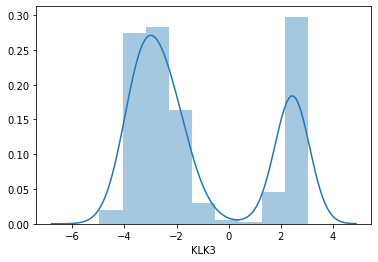

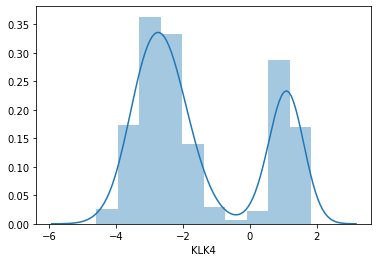

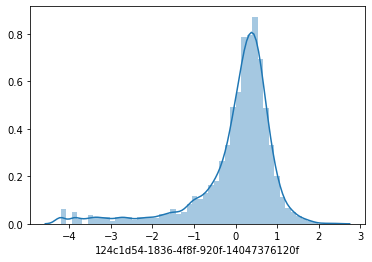

In [38]:
# plot 2 random gene distributions
sns.distplot(df_data_norm.iloc[0, :]); plt.show()
sns.distplot(df_data_norm.iloc[200, :]); plt.show()

# plot a single RNA seq profile distribution
sns.distplot(df_data_norm.iloc[:, 0]); plt.show()

Now let's visualize hierarchical clusters of up and downregulated genes with a heatmap.

/Users/nicolemoiseyev/opt/anaconda3/envs/TCGA/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


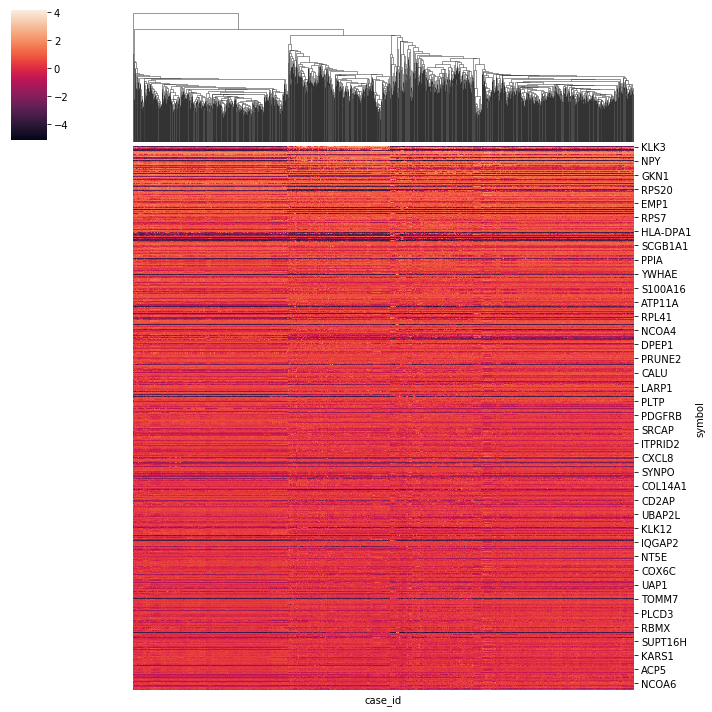

In [39]:
ax = sns.clustermap(df_data_norm,row_cluster=False,xticklabels=False)

We use PCA to initially reduce the dimensionality of the dataset before clustering while still maintaining most of the variability.

In [40]:
# PCA
data_norm_pca = PCA(
  random_state=42,
)

data_norm_pca.fit(df_data_norm.values.T)

df_data_norm_pca = pd.DataFrame(
    data_norm_pca.transform(df_data_norm.values.T),
    index=df_data_norm.T.index
)

df_data_norm_pca.columns = [
    f'PCA-{c}' # ({r:.3f})'
    for c, r in zip(df_data_norm_pca.columns, data_norm_pca.explained_variance_ratio_)
]

df_data_norm_pca.index.name = "case_id"

display(df_data_norm_pca.head())

PCA-0     PCA-1      PCA-2  \
case_id                                                                
124c1d54-1836-4f8f-920f-14047376120f -14.036555  1.968340  13.382212   
261925e3-96e4-440c-8e95-c003d44ab2f2 -11.540272 -0.801644   1.321995   
f5319fd5-beae-4ca8-8f42-45fca5e6a2d2  21.292715 -8.731810  -3.185276   
92252560-5984-41f6-a4b5-a3aa8654c0c8  20.060818 -9.196912  -2.656009   
abe658e0-33f9-4f57-849b-dec4d20964d6 -10.423410 -4.949230  -0.666228   

                                          PCA-3     PCA-4     PCA-5     PCA-6  \
case_id                                                                         
124c1d54-1836-4f8f-920f-14047376120f  14.588502  1.282540 -4.311749  4.682403   
261925e3-96e4-440c-8e95-c003d44ab2f2  -7.475055  2.635878 -7.375880  2.662544   
f5319fd5-beae-4ca8-8f42-45fca5e6a2d2   5.811238  7.589178  4.424733 -0.162770   
92252560-5984-41f6-a4b5-a3aa8654c0c8   3.746539  5.285075  2.322497  1.300575   
abe658e0-33f9-4f57-849b-dec4d20964d6  -9.541173  2.364863 -6.350639 -0.985247   

                                         PCA-7     PCA-8     PCA-9  ...  \
case_id                                                             ...   
124c1d54-1836-4f8f-920f-14047376120f -2.715360  0.681602 -0.703833  ...   
261925e3-96e4-440c-8e95-c003d44ab2f2 -1.024386 -0.947362 -1.191887  ...   
f5319fd5-beae-4ca8-8f42-45fca5e6a2d2  3.586404  2.879983  1.365214  ...   
92252560-5984-41f6-a4b5-a3aa8654c0c8  0.911106 -0.994467 -3.118884  ...   
abe658e0-33f9-4f57-849b-dec4d20964d6 -4.751038 -0.489287  1.288223  ...   

                                      PCA-1550  PCA-1551  PCA-1552  PCA-1553  \
case_id                                                                        
124c1d54-1836-4f8f-920f-14047376120f  0.018078  0.000845 -0.000994 -0.015196   
261925e3-96e4-440c-8e95-c003d44ab2f2  0.015988 -0.002519 -0.015244 -0.010768   
f5319fd5-beae-4ca8-8f42-45fca5e6a2d2  0.008509 -0.015947  0.008983 -0.017918   
92252560-5984-41f6-a4b5-a3aa8654c0c8 -0.003575 -0.004691  0.016292 -0.031190   
abe658e0-33f9-4f57-849b-dec4d20964d6  0.012413  0.000899  0.019800  0.003986   

                                      PCA-1554  PCA-1555  PCA-1556  PCA-1557  \
case_id                                                                        
124c1d54-1836-4f8f-920f-14047376120f -0.001512 -0.001157  0.006160  0.004025   
261925e3-96e4-440c-8e95-c003d44ab2f2  0.007821 -0.016339  0.018145  0.010512   
f5319fd5-beae-4ca8-8f42-45fca5e6a2d2  0.005381  0.006043 -0.003189 -0.023269   
92252560-5984-41f6-a4b5-a3aa8654c0c8  0.005123  0.010565  0.067823  0.004020   
abe658e0-33f9-4f57-849b-dec4d20964d6 -0.000529  0.008361  0.011146  0.012992   

                                      PCA-1558      PCA-1559  
case_id                                                       
124c1d54-1836-4f8f-920f-14047376120f  0.000645  1.826664e-14  
261925e3-96e4-440c-8e95-c003d44ab2f2  0.033766  1.824018e-14  
f5319fd5-beae-4ca8-8f42-45fca5e6a2d2  0.006522  1.807755e-14  
92252560-5984-41f6-a4b5-a3aa8654c0c8 -0.007190  1.926063e-14  
abe658e0-33f9-4f57-849b-dec4d20964d6  0.003357  1.862746e-14  

[5 rows x 1560 columns]

In the two plots below (PCA and UMAP projections), datapoints are color-coded by the selected feature. The size of each point represents the number of reads for that sample.

In [41]:
pca_data = merge(
        df_data_norm_pca[["PCA-0", "PCA-1"]],
        df_library_size,
        df_clinical
      )

axes = {
    "x": [min(df_data_norm_pca["PCA-0"])*1.1, max(df_data_norm_pca["PCA-0"])*1.1],
    "y": [min(df_data_norm_pca["PCA-1"])*1.1, max(df_data_norm_pca["PCA-1"])*1.1]
}
    
scatter_plot(pca_data,"PCA-0", "PCA-1",axes,features)

We further reduce the dimensionality of the dataset using the UMAP (Uniform Manifold Approximation and Projection) technique on the data projected onto the first `n_pca_components` PCA components.

In [42]:
n_neighbors = 10
min_cluster_dist = 0.3
n_pca_components = 10

In [43]:
# UMAP
data_norm_umap = UMAP(
  random_state=42,
  n_components=2,
  n_neighbors=n_neighbors,
  metric='cosine',
  min_dist=min_cluster_dist,
)

# use top n_pca_components components of PCA
n_pca_components = min(n_pca_components,df_data_norm_pca.shape[1])
data_norm_umap.fit(df_data_norm_pca.iloc[:, :n_pca_components].values)

df_data_norm_umap = pd.DataFrame(
  data_norm_umap.transform(df_data_norm_pca.iloc[:, :n_pca_components].values),
  columns=['UMAP-0', 'UMAP-1'],
  index=df_data_norm_pca.index,
)

In [44]:
# project data onto its first 2 UMAP components for visualization
umap_data = merge(
        df_data_norm_umap[["UMAP-0", "UMAP-1"]],
        df_library_size,
        df_clinical
      )

axes = {
    "x": [min(df_data_norm_umap["UMAP-0"])*1.1, max(df_data_norm_umap["UMAP-0"])*1.1],
    "y": [min(df_data_norm_umap["UMAP-1"])*1.1, max(df_data_norm_umap["UMAP-1"])*1.1]
}

scatter_plot(umap_data,"UMAP-0", "UMAP-1",axes,features)

We continue using the first 2 UMAP components.

To compute clusters, we use the Kmeans method, which requires us to define a total number of clusters. We test a range for the number of total clusters. 

For each number of clusters, we compute silhouette scores, which are a measure of how similar an entry is to its own cluster compared to other clusters. We want to maximize similarity within a cluster and differrences between clusters, so the ideal number of clusters is that which produces the highest silhouette score.

In [45]:
silhouette_scores = {}

max_clusters = 25
if (df_data_norm_umap.shape[0] < 25):
    max_clusters = df_data_norm_umap.shape[0]
    max_clusters = max(3,max_clusters)

for n in range(2, max_clusters):
    y_pred = KMeans(n_clusters=n, random_state=42).fit_predict(df_data_norm_umap.values)
    silhouette_scores[n] = silhouette_score(df_data_norm_umap.values, y_pred, metric='cosine')
silhouette_scores = pd.DataFrame([
    {'N Clusters': k, 'Silhouette Score': v}
    for k, v in silhouette_scores.items()
])
best = silhouette_scores.sort_values('Silhouette Score').iloc[-1]

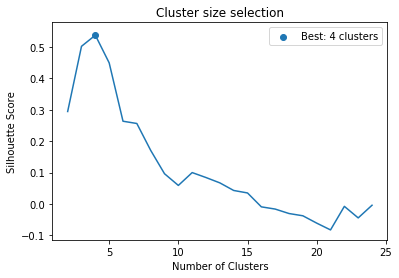

In [46]:
# plot the scores as a function of # of clusters
plt.plot(silhouette_scores['N Clusters'], silhouette_scores['Silhouette Score'])
plt.scatter([best['N Clusters']], [best['Silhouette Score']], label='Best: {} clusters'.format(int(best["N Clusters"])))
plt.legend()
plt.title('Cluster size selection')
plt.ylabel('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.show()

In [47]:
# Compute the Kmeans dataframe using the ideal number of clusters
km = KMeans(n_clusters=int(best['N Clusters']), random_state=42)
df_data_norm_km = pd.DataFrame({
'Cluster': [
    str(c)
    for c in km.fit_predict(df_data_norm_umap.values)
]}, index=df_data_norm_umap.index)

print(f'Computed {len(df_data_norm_km["Cluster"].unique())} clusters')

Computed 4 clusters


Next, we compute differential expression for each cluster. We use the <a href="http://www.maayanlab.net/CD/">Characteristic Direction method</a> for identifying differentially expressed genes among the different clusters.

In [48]:
# Get differential expression for each cluster
diff_expr = {}
for cluster, samples in df_data_norm_km.groupby('Cluster'):
    diff_expr[f"Cluster {cluster} CD"] = characteristic_direction(
        # expression outside of this cluster
        df_data_norm.loc[:, df_data_norm.columns.difference(samples.index)],
        # expression in this cluster
        df_data_norm.loc[:, samples.index],
      )['CD-coefficient']

df_diff_expr = pd.DataFrame(diff_expr)
df_diff_expr = df_diff_expr.sort_values(by='Cluster 0 CD',ascending=True)
df_diff_expr['Symbol'] = df_diff_expr.index.values

display(df_diff_expr.head())

Cluster 0 CD  Cluster 1 CD  Cluster 2 CD  Cluster 3 CD   Symbol
GATA4       -0.178707     -0.081153     -0.055381      0.215289    GATA4
CLDN18      -0.144269     -0.039186     -0.071694      0.178121   CLDN18
CCL25       -0.130048     -0.026626      0.066331      0.071032    CCL25
SLC6A19     -0.113473     -0.023609      0.032258      0.078828  SLC6A19
MUC6        -0.104508      0.009992      0.007645      0.071002     MUC6

We fit a logistic regression on each clinical feature to see which most accurately predict the cluster each datapoint falls into. We also plot up to 5 ROC curves for features that resulted in an AUC $\gt 0.7$. 

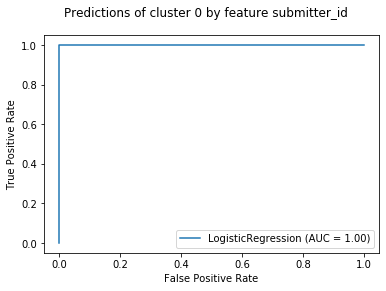

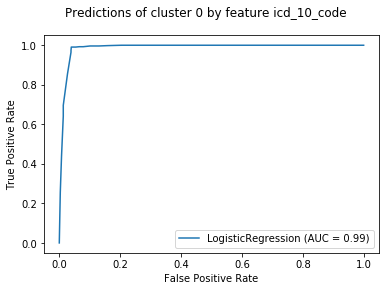

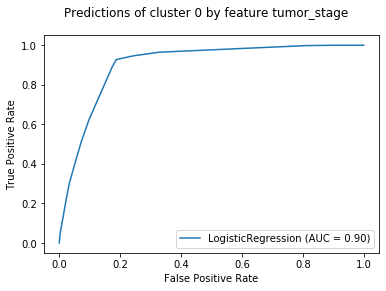

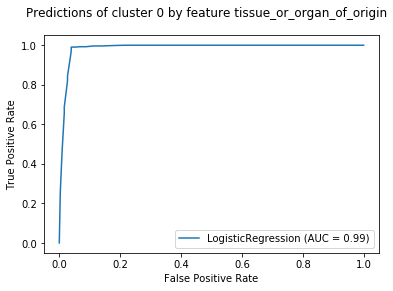

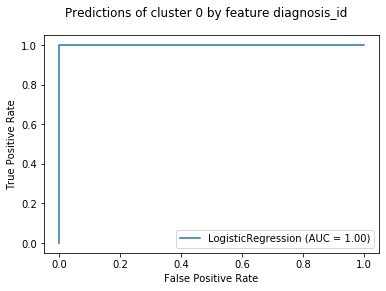

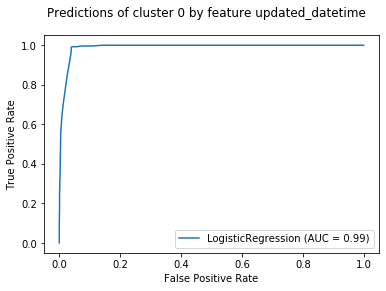

0         1         2         3
Feature                                                  
primary_diagnosis  0.500000  0.500000  0.500000  0.500000
submitter_id       1.000000  1.000000  1.000000  1.000000
icd_10_code        0.986993  1.000000  0.999146  0.977288
age_at_diagnosis   0.409497  0.654144  0.498969  0.409582
tumor_stage        0.902169  0.971429  0.930343  0.709593

In [49]:
# LR
aucs = {}
num_rocs_plotted = 0

for cluster, samples in df_data_norm_km.groupby('Cluster'): 
    aucs[cluster] = {}

    for feature in features:
        lr = LogisticRegression()
        X = df_clinical.copy()
        X = X[feature]
        X = pd.merge(X, df_data_norm_km, left_index = True, right_index = True)

        # drop NAs, and move on if dataset is empty
        X.replace("not reported", None)
        X = X.dropna()
        if (X.shape[0] == 0): continue

        cluster_data = X["Cluster"]
        X = X.drop(columns= ["Cluster"])

        # one-hot encode non numerical data
        if (not isinstance(X[feature][0], (int, float, complex))):
            X = pd.get_dummies(X[feature], prefix=feature)

        y_true = (cluster_data == cluster)

        if (len(set(y_true)) < 2): continue # if we only have one class in the dataset
        lr.fit(X, y_true)


        y_score = lr.predict_proba(X)[:, 1]
        auc_score = roc_auc_score(y_true, y_score)
        aucs[cluster][feature] = auc_score
        
        # plot a few good ROCs, but no more than 5
        if (auc_score > 0.7 and num_rocs_plotted < 6):
            fig = metrics.plot_roc_curve(lr, X, y_true)
            fig.figure_.suptitle(f'Predictions of cluster {cluster} by feature {feature}')
            plt.show()
            num_rocs_plotted += 1

df_cluster_aucs = pd.DataFrame(aucs)
df_cluster_aucs.index.name="Feature"
display(df_cluster_aucs.head())

In [50]:
%%appyter hide_code
'''
# save data
save_data(cancer,
          df_data_norm_km,
          df_data_norm_pca,
          df_data_norm_umap,
          df_diff_expr,
          df_cluster_aucs)
'''

UsageError: Cell magic `%%appyter` not found.


# Enrichr data

We query the Enrichr API for enrichment analysis of the top most upregulated and downregulated genes for each cluster calculated above.

In [51]:
# Util functions
def enrichr_link_from_genes(genes, description='', enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    ''' Functional access to Enrichr API
    '''
    import time, requests
    time.sleep(1)
    resp = requests.post(enrichr_link + '/addList', files={
    'list': (None, '\n'.join(genes)),
    'description': (None, description),
    })
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    # wait a tinybit before returning link (backoff)
    time.sleep(1)
    result = resp.json()
    return dict(result, link=enrichr_link + '/enrich?dataset=' + resp.json()['shortId'])

def enrichr_get_top_results(userListId, bg, enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    import time, requests
    time.sleep(1)
    resp = requests.get(enrichr_link + '/enrich?userListId={}&backgroundType={}'.format(userListId, bg))
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    time.sleep(1)
    return pd.DataFrame(resp.json()[bg], columns=['rank', 'term', 'pvalue', 'zscore', 'combinedscore', 'overlapping_genes', 'adjusted_pvalue', '', ''])

def save_enrichr_data(cancer_type,df_diff_expr,df_clustered_umap,df_all_results,df_cluster_aucs):
    output=f"appyter_data/{cancer_type}"
    os.makedirs(output, exist_ok=True)
    df_diff_expr.to_csv(
        f'{output}/df.tsv',
        sep='\t',
        index=None
    )
    df_clustered_umap.to_csv(
        f'{output}/df_umap.tsv',
        sep='\t',
        index=None
    )
    df_all_results.to_csv(
        f'{output}/df_enrich.tsv',
        sep='\t',
        index=None
    )
    df_cluster_aucs.to_csv(
        f'{output}/cluster_aucs.csv',
        sep='\t',
        index=None
    )

In [52]:
%%appyter hide_code

'''
# Load data
base_path = f"./processed_data/{cancer}"
df = pd.read_csv(base_path + '/diffexp/graphclust/differential_expression.csv')
df_umap = pd.read_csv(base_path + '/umap/2_components/projection.csv', )
df_pca = pd.read_csv(base_path + '/pca/10_components/projection.csv')
df_clusters = pd.read_csv(base_path + '/clustering/graphclust/clusters.csv')
df_cluster_aucs = pd.read_csv(base_path + '/cluster_aucs.csv')
df_clusters['Cluster'] = df_clusters['Cluster'].astype(str)

'''

UsageError: Cell magic `%%appyter` not found.


In [58]:
# Merge data
df_clustered_umap = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_umap, right_on="case_id")
df_clustered_pca = pd.merge(left=df_data_norm_km, left_on="case_id", right=df_data_norm_pca, right_on="case_id")

In [59]:
# Get top Genes for each cluster
top_genes = {}
for cluster in df_clustered_umap['Cluster'].unique():
    fc_col = f'Cluster {cluster} Log2 fold change'
    p_col = f'Cluster {cluster} Adjusted p value'
    cd_col = f'Cluster {cluster} CD'
    if p_col in df_diff_expr.columns:
        # significant and positive fold change sorted by p value
        up_genes = df_diff_expr.loc[
          df_diff_expr[((df_diff_expr[p_col] <= 0.05) & (df_diff_expr[fc_col] > 0))][p_col].sort_values().index,
          'Symbol'
        ].iloc[:top_n_genes].dropna().values

        # significant and negative fold change sorted by p value
        dn_genes = df_diff_expr.loc[
          df_diff_expr[((df_diff_expr[p_col] <= 0.05) & (df_diff_expr[fc_col] < 0))][p_col].sort_values().index,
          'Symbol'
        ].iloc[:top_n_genes].dropna().values
    elif cd_col in df_diff_expr.columns:
        # top up genes
        up_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=False).iloc[:top_n_genes].index, 'Symbol'].values
        # top down genes
        dn_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=True).iloc[:top_n_genes].index, 'Symbol'].values
    else:
        raise Exception('Cant find col for cluster')
    # save results
    top_genes[cluster] = (up_genes, dn_genes)
    

NameError: name 'top_n_genes' is not defined

In [55]:
# Get Enrichr links for each cluster
enrichr_links = {}

for cluster, (up_genes, dn_genes) in top_genes.items():
    up_link, dn_link = None, None
    if up_genes.size:
        up_link = enrichr_link_from_genes(up_genes, 'cluster %s up' % (cluster))
    else:
        print('cluster %s up: empty' % (cluster))
    if dn_genes.size:
        dn_link = enrichr_link_from_genes(dn_genes, 'cluster %s down' % (cluster))
    else:
        print('cluster %s down: empty' % (cluster))
    enrichr_links[cluster] = (up_link, dn_link)

# Grab top results for each cluster
all_results = []
for cluster, (up_link, dn_link) in enrichr_links.items():
    for link_type, link in [('up', up_link), ('down', dn_link)]:
        if link is None:
            continue
    for category, libraries in enrichr_libraries.items():
        for library in libraries:
            try:
                results = enrichr_get_top_results(link['userListId'], library).sort_values('pvalue').iloc[:top_n_results]
                results['link'] = link['link']
                results['library'] = library
                results['category'] = category
                results['direction'] = link_type
                results['cluster'] = cluster
                all_results.append(results)
            except:
                print('{}: {} {} {} cluster {} failed, continuing'.format(link, library, category, link_type, cluster))

df_all_results = pd.concat(all_results).reset_index()

ValueError: No objects to concatenate

In [56]:
# Display a dataframe with clickable enrichr links for display in the notebook

def make_clickable(link):
    return f'<a target="_blank" href="{link}">{link}</a>'

df_clickable = df_all_results.copy()

df_clickable['link'] = df_clickable["link"].apply(make_clickable)

display(HTML(df_clickable.to_html(escape=False)))

NameError: name 'df_all_results' is not defined

In [57]:
%%appyter hide_code
'''
save_enrichr_data(cancer,df_diff_expr,df_clustered_umap,df_all_results)
print("Data saved!")
'''


UsageError: Cell magic `%%appyter` not found.
